In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/rrvf2017/")

In [3]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [4]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [5]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",
                                     with_l2=True,with_l3=True,with_l4=True,with_l5=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [6]:
gc.collect()

0

# cv

In [9]:
from sklearn.linear_model import Ridge,ElasticNetCV

In [10]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [11]:
lag_cols=['weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0', 'const_one', 'visitors', 'geo1_visitors_mean', 'geo2_visitors_mean', 'station_visitors_mean', 'genre_name_visitors_mean', 'day_of_week_visitors_mean', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'visitor_ma2', 'visitor_ma4', 'visitor_ma7', 'visitor_ma14', 'visitor_ma28', 'visitor_ma56', 'visitor_ma112', 'visitor_ma224', 'visitor_sma1', 'visitor_sma2', 'visitor_sma3', 'visitor_sma4', 'visitor_sma8', 'visitor_sma16', 'visitor_sma32', 'visitors_minus_ma28', 'visitors_divid_ma28', 'all_count_y1', 'geo1_count_y1', 'station_count_y1', 'geo2_count_y1', 'all_count_y2', 'geo1_count_y2', 'station_count_y2', 'geo2_count_y2', 'all_count_y3', 'geo1_count_y3', 'station_count_y3', 'geo2_count_y3', 'all_count_y4', 'geo1_count_y4', 'station_count_y4', 'geo2_count_y4', 'all_count_y5', 'geo1_count_y5', 'station_count_y5', 'geo2_count_y5', 'TMAX', 'TMIN', 'TAVG', 'PRCP', 'holiday', 's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio', 'f_t', 'bad_ratio', 'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean']
len(lag_cols)

72

In [12]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                        ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl',
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'                    ,
                    'l4_3006_xgb_fold{}_False_d478.pkl', 'l4_3000_ridge_fold{}_False_d478.pkl', 'l4_3001_lgb_fold{}_False_d478.pkl', 'l4_3003_conv_fold{}_False_d478.pkl'
                   ])

In [14]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle
# indexes=rrvf_data.get_train_valid_indexes()

In [18]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [42]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        gbm = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],verbose=1,n_jobs=8)
        #gbm=Ridge()
        gbm.fit(trainX,trainy)

        models.append(gbm)
        validpred=gbm.predict(validX)
        scores.append(mean_squared_error(validy,validpred))
        print mean_squared_error(trainy,gbm.predict(trainX)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [43]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [44]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        X=np.concatenate([X,np.isnan(X)],1)
        X[np.isnan(X)]=0        
        pred=model.predict(X).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X)
    return pred,dataidx


In [45]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [46]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,trainidx=make_Xy(train_data_from_gen)
    validX,validy,valididx=trainX,trainy,trainidx
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478,model

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [47]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [67]:
j=999
validpreds={}
for offset in range(35,36):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478,model=run_once(columns,data,rawy, None,ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]



35
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 47.473278
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (241895, 2)
train/valid (241895, 2)
train has 241895 records out of 389630 records
no valid set
train # (33989, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 33989 records
no valid set
1889
0
(241895, 1, 40) (241895, 7, 72) (241895, 1) (241895, 1)
(241895, 544) (241895,) (241895,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.29239517 0.29239517
[0.29239517]
-1 mean score 0.29239517
0.252638459206


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.874744  0.054366  0.278629    7  2017-04-16
472     2.507290  2.524648 -0.017358  0.268498    1  2017-04-17
473     2.661330  2.661114  0.000216  0.296764    2  2017-04-18
474     2.754815  2.734376  0.020438  0.258374    3  2017-04-19
475     2.713762  2.701740  0.012022  0.267698    4  2017-04-20
476     2.999000  2.966162  0.032838  0.190203    5  2017-04-21
477     3.075529  3.080068 -0.004539  0.208302    6  2017-04-22

0.252638459206


pred         y     error    error2  day        date
dayidx                                                         
471     2.874744  2.929110  0.054366  0.278629    7  2017-04-16
472     2.524648  2.507290 -0.017358  0.268498    1  2017-04-17
473     2.661114  2.661330  0.000216  0.296764    2  2017-04-18
474     2.734376  2.754815  0.020438  0.258374    3  2017-04-19
475     2.701740  2.713762  0.012022  0.267698    4  2017-04-20
476     2.966162  2.999000  0.032838  0.190203    5  2017-04-21
477     3.080068  3.075529 -0.004539  0.208302    6  2017-04-22

(829, 1088)


In [68]:
model.alpha_,model.l1_ratio_

(0.0017128479549416316, 0.99)

In [69]:
pd.DataFrame(model.alphas_).T

0         1         2         3         4         5         6
0   16.957195  3.391439  2.422456  1.884133  1.784968  1.712848  1.695719
1   15.814337  3.162867  2.259191  1.757149  1.664667  1.597408  1.581434
2   14.748503  2.949701  2.106929  1.638723  1.552474  1.489748  1.474850
3   13.754503  2.750901  1.964929  1.528278  1.447842  1.389344  1.375450
4   12.827496  2.565499  1.832499  1.425277  1.350263  1.295707  1.282750
5   11.962966  2.392593  1.708995  1.329218  1.259260  1.208380  1.196297
6   11.156702  2.231340  1.593815  1.239634  1.174390  1.126940  1.115670
7   10.404777  2.080955  1.486397  1.156086  1.095240  1.050988  1.040478
8    9.703530  1.940706  1.386219  1.078170  1.021424  0.980155  0.970353
9    9.049545  1.809909  1.292792  1.005505  0.952584  0.914095  0.904954
10   8.439636  1.687927  1.205662  0.937737  0.888383  0.852488  0.843964
11   7.870833  1.574167  1.124405  0.874537  0.828509  0.795034  0.787083
12   7.340365  1.468073  1.048624  0.815596  0.772670  0.741451  0.734036
13   6.845649  1.369130  0.977950  0.760628  0.720595  0.691480  0.684565
14   6.384275  1.276855  0.912039  0.709364  0.672029  0.644876  0.638427
15   5.953996  1.190799  0.850571  0.661555  0.626736  0.601414  0.595400
16   5.552717  1.110543  0.793245  0.616969  0.584497  0.560880  0.555272
17   5.178482  1.035696  0.739783  0.575387  0.545103  0.523079  0.517848
18   4.829470  0.965894  0.689924  0.536608  0.508365  0.487825  0.482947
19   4.503980  0.900796  0.643426  0.500442  0.474103  0.454947  0.450398
20   4.200427  0.840085  0.600061  0.466714  0.442150  0.424286  0.420043
21   3.917332  0.783466  0.559619  0.435259  0.412351  0.395690  0.391733
22   3.653317  0.730663  0.521902  0.405924  0.384560  0.369022  0.365332
23   3.407096  0.681419  0.486728  0.378566  0.358642  0.344151  0.340710
24   3.177469  0.635494  0.453924  0.353052  0.334470  0.320956  0.317747
25   2.963318  0.592664  0.423331  0.329258  0.311928  0.299325  0.296332
26   2.763600  0.552720  0.394800  0.307067  0.290905  0.279152  0.276360
27   2.577343  0.515469  0.368192  0.286371  0.271299  0.260338  0.257734
28   2.403639  0.480728  0.343377  0.267071  0.253015  0.242792  0.240364
29   2.241641  0.448328  0.320234  0.249071  0.235962  0.226428  0.224164
..        ...       ...       ...       ...       ...       ...       ...
70   0.128275  0.025655  0.018325  0.014253  0.013503  0.012957  0.012827
71   0.119630  0.023926  0.017090  0.013292  0.012593  0.012084  0.011963
72   0.111567  0.022313  0.015938  0.012396  0.011744  0.011269  0.011157
73   0.104048  0.020810  0.014864  0.011561  0.010952  0.010510  0.010405
74   0.097035  0.019407  0.013862  0.010782  0.010214  0.009802  0.009704
75   0.090495  0.018099  0.012928  0.010055  0.009526  0.009141  0.009050
76   0.084396  0.016879  0.012057  0.009377  0.008884  0.008525  0.008440
77   0.078708  0.015742  0.011244  0.008745  0.008285  0.007950  0.007871
78   0.073404  0.014681  0.010486  0.008156  0.007727  0.007415  0.007340
79   0.068456  0.013691  0.009779  0.007606  0.007206  0.006915  0.006846
80   0.063843  0.012769  0.009120  0.007094  0.006720  0.006449  0.006384
81   0.059540  0.011908  0.008506  0.006616  0.006267  0.006014  0.005954
82   0.055527  0.011105  0.007932  0.006170  0.005845  0.005609  0.005553
83   0.051785  0.010357  0.007398  0.005754  0.005451  0.005231  0.005178
84   0.048295  0.009659  0.006899  0.005366  0.005084  0.004878  0.004829
85   0.045040  0.009008  0.006434  0.005004  0.004741  0.004549  0.004504
86   0.042004  0.008401  0.006001  0.004667  0.004422  0.004243  0.004200
87   0.039173  0.007835  0.005596  0.004353  0.004124  0.003957  0.003917
88   0.036533  0.007307  0.005219  0.004059  0.003846  0.003690  0.003653
89   0.034071  0.006814  0.004867  0.003786  0.003586  0.003442  0.003407
90   0.031775  0.006355  0.004539  0.003531  0.003345  0.003210  0.003177
91   0.029633  0.005927  0.004233  0.003293  0.003119  0.002993  0.002963
92   0.027636  0

In [70]:
pd.DataFrame(model.mse_path_[:,:,0].T ,columns=model.l1_ratio)

0.10      0.50      0.70      0.90      0.95      0.99      1.00
0   0.655988  0.655988  0.655988  0.655988  0.655988  0.655988  0.655988
1   0.655965  0.655965  0.655965  0.655965  0.655965  0.655965  0.655965
2   0.655924  0.655925  0.655925  0.655925  0.655925  0.655925  0.655925
3   0.655882  0.655881  0.655881  0.655881  0.655881  0.655881  0.655881
4   0.655854  0.655854  0.655854  0.655854  0.655855  0.655855  0.655855
5   0.655833  0.655834  0.655834  0.655834  0.655834  0.655834  0.655834
6   0.655792  0.655792  0.655792  0.655792  0.655792  0.655792  0.655792
7   0.655798  0.655798  0.655798  0.655798  0.655798  0.655798  0.655798
8   0.655787  0.655786  0.655786  0.655786  0.655786  0.655786  0.655786
9   0.655757  0.655755  0.655755  0.655755  0.655755  0.655755  0.655755
10  0.655707  0.655708  0.655708  0.655708  0.655708  0.655708  0.655708
11  0.655727  0.655728  0.655728  0.655728  0.655728  0.655728  0.655728
12  0.655707  0.655706  0.655706  0.655706  0.655706  0.655706  0.655706
13  0.655703  0.655715  0.655715  0.655715  0.655715  0.655715  0.655715
14  0.655684  0.655684  0.655685  0.655684  0.655684  0.655684  0.655684
15  0.655042  0.653193  0.652516  0.651953  0.651828  0.651733  0.651710
16  0.630650  0.614660  0.612112  0.607942  0.606485  0.605370  0.605099
17  0.603134  0.576691  0.572780  0.569204  0.566819  0.565005  0.564557
18  0.577260  0.542947  0.538225  0.534405  0.532127  0.529859  0.529307
19  0.553008  0.513117  0.507754  0.503686  0.501795  0.499261  0.498645
20  0.530352  0.486610  0.481072  0.476889  0.475295  0.472631  0.471984
21  0.508728  0.463145  0.457719  0.453525  0.452075  0.449448  0.448800
22  0.488738  0.442489  0.437292  0.433159  0.431712  0.429274  0.428636
23  0.470182  0.424355  0.419418  0.415402  0.413975  0.411711  0.411102
24  0.452344  0.408435  0.403791  0.399920  0.398524  0.396432  0.395849
25  0.436066  0.394479  0.390132  0.386423  0.385068  0.383136  0.382593
26  0.421310  0.382242  0.378192  0.374660  0.373344  0.371563  0.371061
27  0.407967  0.371518  0.367760  0.364401  0.363133  0.361494  0.361033
28  0.396003  0.362127  0.358641  0.355447  0.354243  0.352742  0.352314
29  0.385292  0.353903  0.350664  0.347639  0.346494  0.345118  0.344734
..       ...       ...       ...       ...       ...       ...       ...
70  0.297840  0.295225  0.294641  0.294461  0.294451  0.294441  0.294440
71  0.297718  0.295129  0.294592  0.294439  0.294429  0.294422  0.294421
72  0.297605  0.295053  0.294551  0.294416  0.294405  0.294401  0.294399
73  0.297493  0.294969  0.294515  0.294388  0.294382  0.294377  0.294374
74  0.297390  0.294906  0.294476  0.294364  0.294358  0.294356  0.294354
75  0.297288  0.294837  0.294440  0.294336  0.294332  0.294329  0.294328
76  0.297191  0.294774  0.294409  0.294310  0.294306  0.294301  0.294299
77  0.297097  0.294715  0.294373  0.294285  0.294281  0.294277  0.294277
78  0.297002  0.294658  0.294340  0.294263  0.294259  0.294258  0.294257
79  0.296909  0.294603  0.294309  0.294245  0.294243  0.294241  0.294240
80  0.296819  0.294558  0.294280  0.294228  0.294226  0.294226  0.294225
81  0.296730  0.294508  0.294256  0.294215  0.294213  0.294212  0.294212
82  0.296642  0.294462  0.294235  0.294203  0.294201  0.294200  0.294200
83  0.296555  0.294418  0.294215  0.294191  0.294189  0.294188  0.294188
84  0.296469  0.294378  0.294195  0.294176  0.294174  0.294173  0.294173
85  0.296383  0.294347  0.294178  0.294163  0.294162  0.294163  0.294163
86  0.296297  0.294313  0.294162  0.294155  0.294153  0.294151  0.294151
87  0.296210  0.294281  0.294151  0.294145  0.294143  0.294143  0.294142
88  0.296121  0.294252  0.294141  0.294137  0.294136  0.294135  0.294135
89  0.296036  0.294226  0.294134  0.294127  0.294126  0.294125  0.294125
90  0.295950  0.294203  0.294122  0.294117  0.294116  0.294115  0.294115
91  0.295862  0.294177  0.294113  0.294109  0.294107  0.294105  0.294105
92  0.295776  0.294156  0.294102  0.294094  0.294093  0.294093  0.

In [22]:
j=999
validpreds={}
for offset in range(1,2):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478,model=run_once(columns,data,rawy, None,ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
pickle.dump(validpreds, open('l5_3000_ridge_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 5803 records out of 5803 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(5803, 1, 40) (5803, 7, 72) (5803, 1) (5803, 1)
(5803, 544) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.18066431368e-11 / 5.96046447754e-08
  RuntimeWarning)


0.24159901 0.24159901
[0.24159901]
-1 mean score 0.24159901
0.213432520628


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.931061 -0.001951  0.228090    7  2017-04-16
472     2.507290  2.538945 -0.031655  0.235588    1  2017-04-17
473     2.661330  2.671389 -0.010059  0.249962    2  2017-04-18
474     2.754815  2.745613  0.009202  0.205645    3  2017-04-19
475     2.713762  2.715632 -0.001871  0.231814    4  2017-04-20
476     2.999000  2.989712  0.009288  0.156437    5  2017-04-21
477     3.075529  3.076596 -0.001067  0.186491    6  2017-04-22

0.213432520628


pred         y     error    error2  day        date
dayidx                                                         
471     2.931061  2.929110 -0.001951  0.228090    7  2017-04-16
472     2.538945  2.507290 -0.031655  0.235588    1  2017-04-17
473     2.671389  2.661330 -0.010059  0.249962    2  2017-04-18
474     2.745613  2.754815  0.009202  0.205645    3  2017-04-19
475     2.715632  2.713762 -0.001871  0.231814    4  2017-04-20
476     2.989712  2.999000  0.009288  0.156437    5  2017-04-21
477     3.076596  3.075529 -0.001067  0.186491    6  2017-04-22

(829, 1088)


2
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 6632 records out of 6632 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(6632, 1, 40) (6632, 7, 72) (6632, 1) (6632, 1)
(6632, 544) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.23014307074e-10 / 5.96046447754e-08
  RuntimeWarning)


0.24621262 0.24621262
[0.24621262]
-1 mean score 0.24621262
0.216255441308


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927819  0.001291  0.233677    7  2017-04-16
472     2.507290  2.530089 -0.022799  0.237904    1  2017-04-17
473     2.661330  2.667480 -0.006150  0.250084    2  2017-04-18
474     2.754815  2.751950  0.002864  0.212590    3  2017-04-19
475     2.713762  2.719676 -0.005914  0.235638    4  2017-04-20
476     2.999000  2.992013  0.006986  0.159424    5  2017-04-21
477     3.075529  3.065381  0.010149  0.184472    6  2017-04-22

0.216255441308


pred         y     error    error2  day        date
dayidx                                                         
471     2.927819  2.929110  0.001291  0.233677    7  2017-04-16
472     2.530089  2.507290 -0.022799  0.237904    1  2017-04-17
473     2.667480  2.661330 -0.006150  0.250084    2  2017-04-18
474     2.751950  2.754815  0.002864  0.212590    3  2017-04-19
475     2.719676  2.713762 -0.005914  0.235638    4  2017-04-20
476     2.992013  2.999000  0.006986  0.159424    5  2017-04-21
477     3.065381  3.075529  0.010149  0.184472    6  2017-04-22

(829, 1088)


3
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 7461 records out of 7461 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(7461, 1, 40) (7461, 7, 72) (7461, 1) (7461, 1)
(7461, 544) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.15224593755e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2482919 0.2482919
[0.2482919]
-1 mean score 0.2482919
0.220953837037


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909467  0.019643  0.232153    7  2017-04-16
472     2.507290  2.517740 -0.010450  0.238497    1  2017-04-17
473     2.661330  2.657110  0.004220  0.262393    2  2017-04-18
474     2.754815  2.766591 -0.011776  0.221662    3  2017-04-19
475     2.713762  2.721180 -0.007418  0.240653    4  2017-04-20
476     2.999000  2.983589  0.015410  0.161881    5  2017-04-21
477     3.075529  3.060728  0.014802  0.189438    6  2017-04-22

0.220953837037


pred         y     error    error2  day        date
dayidx                                                         
471     2.909467  2.929110  0.019643  0.232153    7  2017-04-16
472     2.517740  2.507290 -0.010450  0.238497    1  2017-04-17
473     2.657110  2.661330  0.004220  0.262393    2  2017-04-18
474     2.766591  2.754815 -0.011776  0.221662    3  2017-04-19
475     2.721180  2.713762 -0.007418  0.240653    4  2017-04-20
476     2.983589  2.999000  0.015410  0.161881    5  2017-04-21
477     3.060728  3.075529  0.014802  0.189438    6  2017-04-22

(829, 1088)


4
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 8290 records out of 8290 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(8290, 1, 40) (8290, 7, 72) (8290, 1) (8290, 1)
(8290, 544) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.09449463381e-10 / 5.96046447754e-08
  RuntimeWarning)


0.24985303 0.24985303
[0.24985303]
-1 mean score 0.24985303
0.221004590392


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910263  0.018847  0.239827    7  2017-04-16
472     2.507290  2.515129 -0.007838  0.236174    1  2017-04-17
473     2.661330  2.631861  0.029468  0.260189    2  2017-04-18
474     2.754815  2.753339  0.001476  0.216026    3  2017-04-19
475     2.713762  2.718405 -0.004643  0.240830    4  2017-04-20
476     2.999000  2.968395  0.030605  0.166195    5  2017-04-21
477     3.075529  3.055080  0.020449  0.187792    6  2017-04-22

0.221004575491


pred         y     error    error2  day        date
dayidx                                                         
471     2.910263  2.929110  0.018847  0.239827    7  2017-04-16
472     2.515129  2.507290 -0.007838  0.236174    1  2017-04-17
473     2.631861  2.661330  0.029468  0.260189    2  2017-04-18
474     2.753339  2.754815  0.001476  0.216026    3  2017-04-19
475     2.718405  2.713762 -0.004643  0.240830    4  2017-04-20
476     2.968395  2.999000  0.030605  0.166195    5  2017-04-21
477     3.055080  3.075529  0.020449  0.187792    6  2017-04-22

(829, 1088)


5
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 9119 records out of 9119 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(9119, 1, 40) (9119, 7, 72) (9119, 1) (9119, 1)
(9119, 544) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.09248131375e-10 / 5.96046447754e-08
  RuntimeWarning)


0.25173476 0.25173476
[0.25173476]
-1 mean score 0.25173476
0.22351822257


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916166  0.012944  0.235036    7  2017-04-16
472     2.507290  2.526855 -0.019564  0.244973    1  2017-04-17
473     2.661330  2.625515  0.035815  0.263334    2  2017-04-18
474     2.754815  2.734709  0.020106  0.215129    3  2017-04-19
475     2.713762  2.704705  0.009057  0.247240    4  2017-04-20
476     2.999000  2.968420  0.030580  0.169117    5  2017-04-21
477     3.075529  3.051541  0.023988  0.189799    6  2017-04-22

0.22351822257


pred         y     error    error2  day        date
dayidx                                                         
471     2.916166  2.929110  0.012944  0.235036    7  2017-04-16
472     2.526855  2.507290 -0.019564  0.244973    1  2017-04-17
473     2.625515  2.661330  0.035815  0.263334    2  2017-04-18
474     2.734709  2.754815  0.020106  0.215129    3  2017-04-19
475     2.704705  2.713762  0.009057  0.247240    4  2017-04-20
476     2.968420  2.999000  0.030580  0.169117    5  2017-04-21
477     3.051541  3.075529  0.023988  0.189799    6  2017-04-22

(829, 1088)


6
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 15.133374
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 9948 records out of 9948 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(9948, 1, 40) (9948, 7, 72) (9948, 1) (9948, 1)
(9948, 544) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.90668241885e-11 / 5.96046447754e-08
  RuntimeWarning)


0.25270787 0.25270787
[0.25270787]
-1 mean score 0.25270787
0.226861074567


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.926034  0.003076  0.242049    7  2017-04-16
472     2.507290  2.535209 -0.027919  0.251282    1  2017-04-17
473     2.661330  2.629287  0.032043  0.269715    2  2017-04-18
474     2.754815  2.738099  0.016715  0.217530    3  2017-04-19
475     2.713762  2.722387 -0.008626  0.248360    4  2017-04-20
476     2.999000  2.955316  0.043684  0.170653    5  2017-04-21
477     3.075529  3.069416  0.006113  0.188439    6  2017-04-22

0.226861074567


pred         y     error    error2  day        date
dayidx                                                         
471     2.926034  2.929110  0.003076  0.242049    7  2017-04-16
472     2.535209  2.507290 -0.027919  0.251282    1  2017-04-17
473     2.629287  2.661330  0.032043  0.269715    2  2017-04-18
474     2.738099  2.754815  0.016715  0.217530    3  2017-04-19
475     2.722387  2.713762 -0.008626  0.248360    4  2017-04-20
476     2.955316  2.999000  0.043684  0.170653    5  2017-04-21
477     3.069416  3.075529  0.006113  0.188439    6  2017-04-22

(829, 1088)


7
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 16.310143
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 10777 records out of 10777 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(10777, 1, 40) (10777, 7, 72) (10777, 1) (10777, 1)
(10777, 544) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.02596389717e-10 / 5.96046447754e-08
  RuntimeWarning)


0.25502253 0.25502253
[0.25502253]
-1 mean score 0.25502253
0.227504864335


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921781  0.007329  0.245342    7  2017-04-16
472     2.507290  2.545268 -0.037978  0.252167    1  2017-04-17
473     2.661330  2.638700  0.022629  0.271103    2  2017-04-18
474     2.754815  2.730841  0.023973  0.217422    3  2017-04-19
475     2.713762  2.713794 -0.000032  0.250917    4  2017-04-20
476     2.999000  2.978412  0.020588  0.164118    5  2017-04-21
477     3.075529  3.090022 -0.014493  0.191464    6  2017-04-22

0.227504864335


pred         y     error    error2  day        date
dayidx                                                         
471     2.921781  2.929110  0.007329  0.245342    7  2017-04-16
472     2.545268  2.507290 -0.037978  0.252167    1  2017-04-17
473     2.638700  2.661330  0.022629  0.271103    2  2017-04-18
474     2.730841  2.754815  0.023973  0.217422    3  2017-04-19
475     2.713794  2.713762 -0.000032  0.250917    4  2017-04-20
476     2.978412  2.999000  0.020588  0.164118    5  2017-04-21
477     3.090022  3.075529 -0.014493  0.191464    6  2017-04-22

(829, 1088)


8
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 17.574337
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 11606 records out of 11606 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(11606, 1, 40) (11606, 7, 72) (11606, 1) (11606, 1)
(11606, 544) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.09634946954e-10 / 5.96046447754e-08
  RuntimeWarning)


0.25889048 0.25889048
[0.25889048]
-1 mean score 0.25889048
0.232440546155


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.936112 -0.007002  0.254471    7  2017-04-16
472     2.507290  2.548876 -0.041586  0.248175    1  2017-04-17
473     2.661330  2.652253  0.009077  0.275425    2  2017-04-18
474     2.754815  2.737522  0.017293  0.228503    3  2017-04-19
475     2.713762  2.715030 -0.001268  0.254968    4  2017-04-20
476     2.999000  2.965574  0.033426  0.173330    5  2017-04-21
477     3.075529  3.090677 -0.015148  0.192211    6  2017-04-22

0.232440546155


pred         y     error    error2  day        date
dayidx                                                         
471     2.936112  2.929110 -0.007002  0.254471    7  2017-04-16
472     2.548876  2.507290 -0.041586  0.248175    1  2017-04-17
473     2.652253  2.661330  0.009077  0.275425    2  2017-04-18
474     2.737522  2.754815  0.017293  0.228503    3  2017-04-19
475     2.715030  2.713762 -0.001268  0.254968    4  2017-04-20
476     2.965574  2.999000  0.033426  0.173330    5  2017-04-21
477     3.090677  3.075529 -0.015148  0.192211    6  2017-04-22

(829, 1088)


9
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 18.806503
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 12435 records out of 12435 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(12435, 1, 40) (12435, 7, 72) (12435, 1) (12435, 1)
(12435, 544) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0081343399e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26108024 0.26108024
[0.26108024]
-1 mean score 0.26108024
0.23187969625


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.924083  0.005027  0.255135    7  2017-04-16
472     2.507290  2.554864 -0.047574  0.248260    1  2017-04-17
473     2.661330  2.669130 -0.007800  0.277812    2  2017-04-18
474     2.754815  2.734319  0.020495  0.230360    3  2017-04-19
475     2.713762  2.716835 -0.003073  0.249372    4  2017-04-20
476     2.999000  2.969972  0.029028  0.170604    5  2017-04-21
477     3.075529  3.084740 -0.009211  0.191616    6  2017-04-22

0.231879681349


pred         y     error    error2  day        date
dayidx                                                         
471     2.924083  2.929110  0.005027  0.255135    7  2017-04-16
472     2.554864  2.507290 -0.047574  0.248260    1  2017-04-17
473     2.669130  2.661330 -0.007800  0.277812    2  2017-04-18
474     2.734319  2.754815  0.020495  0.230360    3  2017-04-19
475     2.716835  2.713762 -0.003073  0.249372    4  2017-04-20
476     2.969972  2.999000  0.029028  0.170604    5  2017-04-21
477     3.084740  3.075529 -0.009211  0.191616    6  2017-04-22

(829, 1088)


10
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 19.926521
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 13264 records out of 13264 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(13264, 1, 40) (13264, 7, 72) (13264, 1) (13264, 1)
(13264, 544) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.32293617306e-11 / 5.96046447754e-08
  RuntimeWarning)


0.26173288 0.26173288
[0.26173288]
-1 mean score 0.26173288
0.231341570616


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.924509  0.004601  0.250498    7  2017-04-16
472     2.507290  2.540381 -0.033091  0.248949    1  2017-04-17
473     2.661330  2.670312 -0.008982  0.277724    2  2017-04-18
474     2.754815  2.749109  0.005705  0.226293    3  2017-04-19
475     2.713762  2.724425 -0.010663  0.251002    4  2017-04-20
476     2.999000  2.974606  0.024394  0.171819    5  2017-04-21
477     3.075529  3.092906 -0.017377  0.193106    6  2017-04-22

0.231341570616


pred         y     error    error2  day        date
dayidx                                                         
471     2.924509  2.929110  0.004601  0.250498    7  2017-04-16
472     2.540381  2.507290 -0.033091  0.248949    1  2017-04-17
473     2.670312  2.661330 -0.008982  0.277724    2  2017-04-18
474     2.749109  2.754815  0.005705  0.226293    3  2017-04-19
475     2.724425  2.713762 -0.010663  0.251002    4  2017-04-20
476     2.974606  2.999000  0.024394  0.171819    5  2017-04-21
477     3.092906  3.075529 -0.017377  0.193106    6  2017-04-22

(829, 1088)


11
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 21.05768
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 14093 records out of 14093 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(14093, 1, 40) (14093, 7, 72) (14093, 1) (14093, 1)
(14093, 544) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.76117311979e-11 / 5.96046447754e-08
  RuntimeWarning)


0.26253426 0.26253426
[0.26253426]
-1 mean score 0.26253426
0.231857985258


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913882  0.015228  0.248564    7  2017-04-16
472     2.507290  2.544975 -0.037684  0.250765    1  2017-04-17
473     2.661330  2.662418 -0.001088  0.278961    2  2017-04-18
474     2.754815  2.725932  0.028883  0.228579    3  2017-04-19
475     2.713762  2.732542 -0.018781  0.250539    4  2017-04-20
476     2.999000  2.981353  0.017647  0.173058    5  2017-04-21
477     3.075529  3.073873  0.001656  0.192539    6  2017-04-22

0.231857985258


pred         y     error    error2  day        date
dayidx                                                         
471     2.913882  2.929110  0.015228  0.248564    7  2017-04-16
472     2.544975  2.507290 -0.037684  0.250765    1  2017-04-17
473     2.662418  2.661330 -0.001088  0.278961    2  2017-04-18
474     2.725932  2.754815  0.028883  0.228579    3  2017-04-19
475     2.732542  2.713762 -0.018781  0.250539    4  2017-04-20
476     2.981353  2.999000  0.017647  0.173058    5  2017-04-21
477     3.073873  3.075529  0.001656  0.192539    6  2017-04-22

(829, 1088)


12
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 22.115147
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 14922 records out of 14922 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(14922, 1, 40) (14922, 7, 72) (14922, 1) (14922, 1)
(14922, 544) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0687126184e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26407006 0.26407006
[0.26407006]
-1 mean score 0.26407006
0.232769086957


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907153  0.021957  0.252864    7  2017-04-16
472     2.507290  2.553088 -0.045797  0.249935    1  2017-04-17
473     2.661330  2.667715 -0.006385  0.276082    2  2017-04-18
474     2.754815  2.725794  0.029021  0.229827    3  2017-04-19
475     2.713762  2.734294 -0.020532  0.249959    4  2017-04-20
476     2.999000  2.977925  0.021075  0.176734    5  2017-04-21
477     3.075529  3.081099 -0.005570  0.193983    6  2017-04-22

0.232769086957


pred         y     error    error2  day        date
dayidx                                                         
471     2.907153  2.929110  0.021957  0.252864    7  2017-04-16
472     2.553088  2.507290 -0.045797  0.249935    1  2017-04-17
473     2.667715  2.661330 -0.006385  0.276082    2  2017-04-18
474     2.725794  2.754815  0.029021  0.229827    3  2017-04-19
475     2.734294  2.713762 -0.020532  0.249959    4  2017-04-20
476     2.977925  2.999000  0.021075  0.176734    5  2017-04-21
477     3.081099  3.075529 -0.005570  0.193983    6  2017-04-22

(829, 1088)


13
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 23.15517
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 15751 records out of 15751 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(15751, 1, 40) (15751, 7, 72) (15751, 1) (15751, 1)
(15751, 544) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.10177686419e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26478708 0.26478708
[0.26478708]
-1 mean score 0.26478708
0.234094023705


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909616  0.019494  0.257285    7  2017-04-16
472     2.507290  2.537849 -0.030559  0.255420    1  2017-04-17
473     2.661330  2.671505 -0.010175  0.277370    2  2017-04-18
474     2.754815  2.729065  0.025750  0.232496    3  2017-04-19
475     2.713762  2.734163 -0.020402  0.252927    4  2017-04-20
476     2.999000  3.003973 -0.004974  0.173613    5  2017-04-21
477     3.075529  3.067031  0.008498  0.189548    6  2017-04-22

0.234094023705


pred         y     error    error2  day        date
dayidx                                                         
471     2.909616  2.929110  0.019494  0.257285    7  2017-04-16
472     2.537849  2.507290 -0.030559  0.255420    1  2017-04-17
473     2.671505  2.661330 -0.010175  0.277370    2  2017-04-18
474     2.729065  2.754815  0.025750  0.232496    3  2017-04-19
475     2.734163  2.713762 -0.020402  0.252927    4  2017-04-20
476     3.003973  2.999000 -0.004974  0.173613    5  2017-04-21
477     3.067031  3.075529  0.008498  0.189548    6  2017-04-22

(829, 1088)


14
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 24.22639
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 16580 records out of 16580 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(16580, 1, 40) (16580, 7, 72) (16580, 1) (16580, 1)
(16580, 544) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.07382165659e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26605672 0.26605672
[0.26605672]
-1 mean score 0.26605672
0.234409302473


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910284  0.018826  0.260982    7  2017-04-16
472     2.507290  2.531192 -0.023902  0.251031    1  2017-04-17
473     2.661330  2.662962 -0.001632  0.280357    2  2017-04-18
474     2.754815  2.724798  0.030017  0.236007    3  2017-04-19
475     2.713762  2.731569 -0.017807  0.248745    4  2017-04-20
476     2.999000  3.010410 -0.011410  0.166802    5  2017-04-21
477     3.075529  3.078924 -0.003395  0.196939    6  2017-04-22

0.234409287572


pred         y     error    error2  day        date
dayidx                                                         
471     2.910284  2.929110  0.018826  0.260982    7  2017-04-16
472     2.531192  2.507290 -0.023902  0.251031    1  2017-04-17
473     2.662962  2.661330 -0.001632  0.280357    2  2017-04-18
474     2.724798  2.754815  0.030017  0.236007    3  2017-04-19
475     2.731569  2.713762 -0.017807  0.248745    4  2017-04-20
476     3.010410  2.999000 -0.011410  0.166802    5  2017-04-21
477     3.078924  3.075529 -0.003395  0.196939    6  2017-04-22

(829, 1088)


15
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 25.357664
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 17409 records out of 17409 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(17409, 1, 40) (17409, 7, 72) (17409, 1) (17409, 1)
(17409, 544) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.92427737212e-11 / 5.96046447754e-08
  RuntimeWarning)


0.26941046 0.26941046
[0.26941046]
-1 mean score 0.26941046
0.240324571729


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911879  0.017231  0.271173    7  2017-04-16
472     2.507290  2.538789 -0.031498  0.255197    1  2017-04-17
473     2.661330  2.649491  0.011839  0.290065    2  2017-04-18
474     2.754815  2.717011  0.037803  0.234372    3  2017-04-19
475     2.713762  2.731037 -0.017275  0.258624    4  2017-04-20
476     2.999000  3.005341 -0.006341  0.176024    5  2017-04-21
477     3.075529  3.075860 -0.000330  0.196818    6  2017-04-22

0.24032458663


pred         y     error    error2  day        date
dayidx                                                         
471     2.911879  2.929110  0.017231  0.271173    7  2017-04-16
472     2.538789  2.507290 -0.031498  0.255197    1  2017-04-17
473     2.649491  2.661330  0.011839  0.290065    2  2017-04-18
474     2.717011  2.754815  0.037803  0.234372    3  2017-04-19
475     2.731037  2.713762 -0.017275  0.258624    4  2017-04-20
476     3.005341  2.999000 -0.006341  0.176024    5  2017-04-21
477     3.075860  3.075529 -0.000330  0.196818    6  2017-04-22

(829, 1088)


16
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 26.465925
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 18238 records out of 18238 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(18238, 1, 40) (18238, 7, 72) (18238, 1) (18238, 1)
(18238, 544) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.65255022009e-11 / 5.96046447754e-08
  RuntimeWarning)


0.27145338 0.27145338
[0.27145338]
-1 mean score 0.27145338
0.240768179297


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907813  0.021297  0.270668    7  2017-04-16
472     2.507290  2.542948 -0.035657  0.256933    1  2017-04-17
473     2.661330  2.642153  0.019177  0.289377    2  2017-04-18
474     2.754815  2.709607  0.045208  0.237258    3  2017-04-19
475     2.713762  2.720732 -0.006971  0.256813    4  2017-04-20
476     2.999000  2.995426  0.003574  0.178321    5  2017-04-21
477     3.075529  3.058443  0.017086  0.196007    6  2017-04-22

0.240768179297


pred         y     error    error2  day        date
dayidx                                                         
471     2.907813  2.929110  0.021297  0.270668    7  2017-04-16
472     2.542948  2.507290 -0.035657  0.256933    1  2017-04-17
473     2.642153  2.661330  0.019177  0.289377    2  2017-04-18
474     2.709607  2.754815  0.045208  0.237258    3  2017-04-19
475     2.720732  2.713762 -0.006970  0.256813    4  2017-04-20
476     2.995426  2.999000  0.003574  0.178321    5  2017-04-21
477     3.058443  3.075529  0.017086  0.196007    6  2017-04-22

(829, 1088)


17
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 27.605818
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 19067 records out of 19067 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(19067, 1, 40) (19067, 7, 72) (19067, 1) (19067, 1)
(19067, 544) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.08317528558e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27233228 0.27233228
[0.27233228]
-1 mean score 0.27233228
0.242075890303


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913512  0.015598  0.269235    7  2017-04-16
472     2.507290  2.524484 -0.017194  0.257261    1  2017-04-17
473     2.661330  2.635360  0.025970  0.290712    2  2017-04-18
474     2.754815  2.705449  0.049366  0.247385    3  2017-04-19
475     2.713762  2.716756 -0.002994  0.255847    4  2017-04-20
476     2.999000  2.993728  0.005272  0.178706    5  2017-04-21
477     3.075529  3.054527  0.021002  0.195385    6  2017-04-22

0.242075890303


pred         y     error    error2  day        date
dayidx                                                         
471     2.913512  2.929110  0.015598  0.269235    7  2017-04-16
472     2.524484  2.507290 -0.017194  0.257261    1  2017-04-17
473     2.635360  2.661330  0.025970  0.290712    2  2017-04-18
474     2.705449  2.754815  0.049366  0.247385    3  2017-04-19
475     2.716756  2.713762 -0.002994  0.255847    4  2017-04-20
476     2.993728  2.999000  0.005272  0.178706    5  2017-04-21
477     3.054527  3.075529  0.021002  0.195385    6  2017-04-22

(829, 1088)


18
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 28.75126
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 19896 records out of 19896 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(19896, 1, 40) (19896, 7, 72) (19896, 1) (19896, 1)
(19896, 544) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.00918731705e-10 / 5.96046447754e-08
  RuntimeWarning)


0.273195 0.273195
[0.273195]
-1 mean score 0.273195
0.244543239474


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914201  0.014909  0.274465    7  2017-04-16
472     2.507290  2.523656 -0.016365  0.260865    1  2017-04-17
473     2.661330  2.626477  0.034853  0.290361    2  2017-04-18
474     2.754815  2.714378  0.040437  0.239303    3  2017-04-19
475     2.713762  2.720000 -0.006239  0.264935    4  2017-04-20
476     2.999000  2.990284  0.008716  0.181155    5  2017-04-21
477     3.075529  3.052237  0.023293  0.200719    6  2017-04-22

0.244543239474


pred         y     error    error2  day        date
dayidx                                                         
471     2.914201  2.929110  0.014909  0.274465    7  2017-04-16
472     2.523656  2.507290 -0.016365  0.260865    1  2017-04-17
473     2.626477  2.661330  0.034853  0.290361    2  2017-04-18
474     2.714377  2.754815  0.040437  0.239303    3  2017-04-19
475     2.720000  2.713762 -0.006239  0.264935    4  2017-04-20
476     2.990283  2.999000  0.008716  0.181155    5  2017-04-21
477     3.052237  3.075529  0.023293  0.200719    6  2017-04-22

(829, 1088)


19
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 29.798643
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 20725 records out of 20725 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(20725, 1, 40) (20725, 7, 72) (20725, 1) (20725, 1)
(20725, 544) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.58733717416e-11 / 5.96046447754e-08
  RuntimeWarning)


0.27396876 0.27396876
[0.27396876]
-1 mean score 0.27396876
0.247167810798


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.934771 -0.005661  0.276952    7  2017-04-16
472     2.507290  2.525506 -0.018216  0.262535    1  2017-04-17
473     2.661330  2.619502  0.041828  0.290780    2  2017-04-18
474     2.754815  2.701549  0.053265  0.245380    3  2017-04-19
475     2.713762  2.706314  0.007447  0.264167    4  2017-04-20
476     2.999000  2.979769  0.019231  0.184588    5  2017-04-21
477     3.075529  3.046568  0.028961  0.205774    6  2017-04-22

0.247167810798


pred         y     error    error2  day        date
dayidx                                                         
471     2.934771  2.929110 -0.005661  0.276952    7  2017-04-16
472     2.525506  2.507290 -0.018216  0.262535    1  2017-04-17
473     2.619502  2.661330  0.041828  0.290780    2  2017-04-18
474     2.701549  2.754815  0.053265  0.245380    3  2017-04-19
475     2.706314  2.713762  0.007447  0.264167    4  2017-04-20
476     2.979769  2.999000  0.019231  0.184588    5  2017-04-21
477     3.046568  3.075529  0.028961  0.205774    6  2017-04-22

(829, 1088)


20
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 30.796307
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 21554 records out of 21554 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(21554, 1, 40) (21554, 7, 72) (21554, 1) (21554, 1)
(21554, 544) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.55432122307e-11 / 5.96046447754e-08
  RuntimeWarning)


0.27428705 0.27428705
[0.27428705]
-1 mean score 0.27428705
0.244258627295


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.925401  0.003709  0.266924    7  2017-04-16
472     2.507290  2.546258 -0.038968  0.260838    1  2017-04-17
473     2.661330  2.625581  0.035749  0.284475    2  2017-04-18
474     2.754815  2.705631  0.049184  0.244668    3  2017-04-19
475     2.713762  2.705673  0.008088  0.270230    4  2017-04-20
476     2.999000  2.971623  0.027376  0.180376    5  2017-04-21
477     3.075529  3.058903  0.016626  0.202298    6  2017-04-22

0.244258627295


pred         y     error    error2  day        date
dayidx                                                         
471     2.925401  2.929110  0.003709  0.266924    7  2017-04-16
472     2.546258  2.507290 -0.038968  0.260838    1  2017-04-17
473     2.625581  2.661330  0.035749  0.284475    2  2017-04-18
474     2.705631  2.754815  0.049184  0.244668    3  2017-04-19
475     2.705673  2.713762  0.008088  0.270230    4  2017-04-20
476     2.971623  2.999000  0.027376  0.180376    5  2017-04-21
477     3.058903  3.075529  0.016626  0.202298    6  2017-04-22

(829, 1088)


21
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 31.792852
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 22383 records out of 22383 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(22383, 1, 40) (22383, 7, 72) (22383, 1) (22383, 1)
(22383, 544) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.90407608756e-11 / 5.96046447754e-08
  RuntimeWarning)


0.27539903 0.27539903
[0.27539903]
-1 mean score 0.27539903
0.248942017555


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903399  0.025711  0.280733    7  2017-04-16
472     2.507290  2.528249 -0.020959  0.261618    1  2017-04-17
473     2.661330  2.636791  0.024539  0.291706    2  2017-04-18
474     2.754815  2.707843  0.046972  0.246495    3  2017-04-19
475     2.713762  2.685623  0.028138  0.270514    4  2017-04-20
476     2.999000  2.967054  0.031945  0.188025    5  2017-04-21
477     3.075529  3.054095  0.021434  0.203503    6  2017-04-22

0.248942002654


pred         y     error    error2  day        date
dayidx                                                         
471     2.903399  2.929110  0.025711  0.280733    7  2017-04-16
472     2.528249  2.507290 -0.020959  0.261618    1  2017-04-17
473     2.636791  2.661330  0.024539  0.291706    2  2017-04-18
474     2.707843  2.754815  0.046972  0.246495    3  2017-04-19
475     2.685623  2.713762  0.028138  0.270514    4  2017-04-20
476     2.967055  2.999000  0.031945  0.188025    5  2017-04-21
477     3.054095  3.075529  0.021434  0.203503    6  2017-04-22

(829, 1088)


22
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 32.870983
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 23212 records out of 23212 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(23212, 1, 40) (23212, 7, 72) (23212, 1) (23212, 1)
(23212, 544) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.17382828089e-11 / 5.96046447754e-08
  RuntimeWarning)


0.27790204 0.27790204
[0.27790204]
-1 mean score 0.27790204
0.248546928167


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909856  0.019254  0.272904    7  2017-04-16
472     2.507290  2.509266 -0.001976  0.264461    1  2017-04-17
473     2.661330  2.640476  0.020854  0.285643    2  2017-04-18
474     2.754815  2.721792  0.033022  0.247952    3  2017-04-19
475     2.713762  2.697308  0.016454  0.274838    4  2017-04-20
476     2.999000  2.961541  0.037459  0.188373    5  2017-04-21
477     3.075529  3.046150  0.029379  0.205658    6  2017-04-22

0.248546913266


pred         y     error    error2  day        date
dayidx                                                         
471     2.909856  2.929110  0.019254  0.272904    7  2017-04-16
472     2.509266  2.507290 -0.001976  0.264461    1  2017-04-17
473     2.640476  2.661330  0.020854  0.285643    2  2017-04-18
474     2.721792  2.754815  0.033022  0.247952    3  2017-04-19
475     2.697308  2.713762  0.016454  0.274838    4  2017-04-20
476     2.961541  2.999000  0.037459  0.188373    5  2017-04-21
477     3.046150  3.075529  0.029379  0.205658    6  2017-04-22

(829, 1088)


23
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 33.974537
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 24041 records out of 24041 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(24041, 1, 40) (24041, 7, 72) (24041, 1) (24041, 1)
(24041, 544) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.85153625344e-11 / 5.96046447754e-08
  RuntimeWarning)


0.27928936 0.27928936
[0.27928936]
-1 mean score 0.27928936
0.247686356306


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909286  0.019824  0.269841    7  2017-04-16
472     2.507290  2.505350  0.001941  0.263811    1  2017-04-17
473     2.661330  2.651850  0.009480  0.286973    2  2017-04-18
474     2.754815  2.719076  0.035738  0.246816    3  2017-04-19
475     2.713762  2.714193 -0.000432  0.270907    4  2017-04-20
476     2.999000  2.970668  0.028332  0.192574    5  2017-04-21
477     3.075529  3.046042  0.029487  0.202883    6  2017-04-22

0.247686386108


pred         y     error    error2  day        date
dayidx                                                         
471     2.909286  2.929110  0.019824  0.269841    7  2017-04-16
472     2.505350  2.507290  0.001941  0.263811    1  2017-04-17
473     2.651850  2.661330  0.009480  0.286973    2  2017-04-18
474     2.719076  2.754815  0.035738  0.246816    3  2017-04-19
475     2.714193  2.713762 -0.000432  0.270907    4  2017-04-20
476     2.970668  2.999000  0.028332  0.192574    5  2017-04-21
477     3.046042  3.075529  0.029487  0.202883    6  2017-04-22

(829, 1088)


24
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 35.208443
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 24870 records out of 24870 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(24870, 1, 40) (24870, 7, 72) (24870, 1) (24870, 1)
(24870, 544) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.20516888136e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27982858 0.27982858
[0.27982858]
-1 mean score 0.27982858
0.246785208583


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919645  0.009465  0.270630    7  2017-04-16
472     2.507290  2.504267  0.003024  0.261499    1  2017-04-17
473     2.661330  2.642763  0.018567  0.286709    2  2017-04-18
474     2.754815  2.733382  0.021433  0.245162    3  2017-04-19
475     2.713762  2.701771  0.011990  0.269720    4  2017-04-20
476     2.999000  2.986336  0.012663  0.189383    5  2017-04-21
477     3.075529  3.054670  0.020859  0.204393    6  2017-04-22

0.246785193682


pred         y     error    error2  day        date
dayidx                                                         
471     2.919645  2.929110  0.009465  0.270630    7  2017-04-16
472     2.504267  2.507290  0.003024  0.261499    1  2017-04-17
473     2.642763  2.661330  0.018567  0.286709    2  2017-04-18
474     2.733382  2.754815  0.021433  0.245162    3  2017-04-19
475     2.701771  2.713762  0.011990  0.269720    4  2017-04-20
476     2.986336  2.999000  0.012663  0.189383    5  2017-04-21
477     3.054670  3.075529  0.020859  0.204393    6  2017-04-22

(829, 1088)


25
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 36.335064
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 25699 records out of 25699 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(25699, 1, 40) (25699, 7, 72) (25699, 1) (25699, 1)
(25699, 544) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.18445919739e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28062543 0.28062543
[0.28062543]
-1 mean score 0.28062543
0.248914435506


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911893  0.017217  0.270207    7  2017-04-16
472     2.507290  2.493256  0.014035  0.265843    1  2017-04-17
473     2.661330  2.640278  0.021052  0.291456    2  2017-04-18
474     2.754815  2.711451  0.043363  0.250440    3  2017-04-19
475     2.713762  2.685340  0.028422  0.270882    4  2017-04-20
476     2.999000  2.984180  0.014820  0.186220    5  2017-04-21
477     3.075529  3.072550  0.002979  0.207351    6  2017-04-22

0.248914435506


pred         y     error    error2  day        date
dayidx                                                         
471     2.911893  2.929110  0.017217  0.270207    7  2017-04-16
472     2.493256  2.507290  0.014035  0.265843    1  2017-04-17
473     2.640278  2.661330  0.021052  0.291456    2  2017-04-18
474     2.711451  2.754815  0.043364  0.250440    3  2017-04-19
475     2.685340  2.713762  0.028422  0.270882    4  2017-04-20
476     2.984180  2.999000  0.014820  0.186220    5  2017-04-21
477     3.072550  3.075529  0.002979  0.207351    6  2017-04-22

(829, 1088)


26
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 37.374123
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 26528 records out of 26528 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(26528, 1, 40) (26528, 7, 72) (26528, 1) (26528, 1)
(26528, 544) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0937952627e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28174746 0.28174746
[0.28174746]
-1 mean score 0.28174746
0.250499516726


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916038  0.013072  0.279929    7  2017-04-16
472     2.507290  2.506011  0.001279  0.261022    1  2017-04-17
473     2.661330  2.633741  0.027589  0.293913    2  2017-04-18
474     2.754815  2.718260  0.036555  0.245671    3  2017-04-19
475     2.713762  2.682424  0.031337  0.278502    4  2017-04-20
476     2.999000  2.979859  0.019141  0.190115    5  2017-04-21
477     3.075529  3.060617  0.014912  0.204345    6  2017-04-22

0.250499516726


pred         y     error    error2  day        date
dayidx                                                         
471     2.916038  2.929110  0.013072  0.279929    7  2017-04-16
472     2.506011  2.507290  0.001279  0.261022    1  2017-04-17
473     2.633741  2.661330  0.027589  0.293913    2  2017-04-18
474     2.718260  2.754815  0.036555  0.245671    3  2017-04-19
475     2.682424  2.713762  0.031337  0.278502    4  2017-04-20
476     2.979859  2.999000  0.019141  0.190115    5  2017-04-21
477     3.060617  3.075529  0.014912  0.204345    6  2017-04-22

(829, 1088)


27
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 38.450596
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 27357 records out of 27357 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(27357, 1, 40) (27357, 7, 72) (27357, 1) (27357, 1)
(27357, 544) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.10121758934e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28241223 0.28241223
[0.28241223]
-1 mean score 0.28241223
0.249818399549


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899348  0.029762  0.277176    7  2017-04-16
472     2.507290  2.507416 -0.000126  0.265397    1  2017-04-17
473     2.661330  2.647349  0.013980  0.291375    2  2017-04-18
474     2.754815  2.725779  0.029036  0.246854    3  2017-04-19
475     2.713762  2.687935  0.025827  0.271999    4  2017-04-20
476     2.999000  2.973647  0.025352  0.192146    5  2017-04-21
477     3.075529  3.064032  0.011497  0.203780    6  2017-04-22

0.249818399549


pred         y     error    error2  day        date
dayidx                                                         
471     2.899348  2.929110  0.029762  0.277176    7  2017-04-16
472     2.507416  2.507290 -0.000126  0.265397    1  2017-04-17
473     2.647350  2.661330  0.013980  0.291375    2  2017-04-18
474     2.725779  2.754815  0.029036  0.246854    3  2017-04-19
475     2.687935  2.713762  0.025827  0.271999    4  2017-04-20
476     2.973647  2.999000  0.025352  0.192146    5  2017-04-21
477     3.064032  3.075529  0.011497  0.203780    6  2017-04-22

(829, 1088)


28
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 39.47981
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 28186 records out of 28186 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(28186, 1, 40) (28186, 7, 72) (28186, 1) (28186, 1)
(28186, 544) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2036147079e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28273997 0.28273997
[0.28273997]
-1 mean score 0.28273997
0.252317845821


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917471  0.011639  0.283496    7  2017-04-16
472     2.507290  2.514710 -0.007420  0.269732    1  2017-04-17
473     2.661330  2.640608  0.020722  0.292439    2  2017-04-18
474     2.754815  2.724730  0.030084  0.250207    3  2017-04-19
475     2.713762  2.695135  0.018627  0.275799    4  2017-04-20
476     2.999000  2.989681  0.009319  0.188776    5  2017-04-21
477     3.075529  3.059374  0.016156  0.205775    6  2017-04-22

0.252317845821


pred         y     error    error2  day        date
dayidx                                                         
471     2.917471  2.929110  0.011639  0.283496    7  2017-04-16
472     2.514710  2.507290 -0.007420  0.269732    1  2017-04-17
473     2.640608  2.661330  0.020722  0.292439    2  2017-04-18
474     2.724730  2.754815  0.030084  0.250207    3  2017-04-19
475     2.695135  2.713762  0.018627  0.275799    4  2017-04-20
476     2.989681  2.999000  0.009319  0.188776    5  2017-04-21
477     3.059374  3.075529  0.016156  0.205775    6  2017-04-22

(829, 1088)


29
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 40.793427
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 29015 records out of 29015 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(29015, 1, 40) (29015, 7, 72) (29015, 1) (29015, 1)
(29015, 544) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.64101229406e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2857062 0.2857062
[0.2857062]
-1 mean score 0.2857062
0.25040858984


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909189  0.019921  0.268652    7  2017-04-16
472     2.507290  2.513096 -0.005805  0.262315    1  2017-04-17
473     2.661330  2.635295  0.026034  0.297173    2  2017-04-18
474     2.754815  2.725784  0.029031  0.252112    3  2017-04-19
475     2.713762  2.699048  0.014713  0.274120    4  2017-04-20
476     2.999000  2.999969 -0.000969  0.188877    5  2017-04-21
477     3.075529  3.062435  0.013094  0.209611    6  2017-04-22

0.25040858984


pred         y     error    error2  day        date
dayidx                                                         
471     2.909189  2.929110  0.019921  0.268652    7  2017-04-16
472     2.513096  2.507290 -0.005805  0.262315    1  2017-04-17
473     2.635295  2.661330  0.026034  0.297173    2  2017-04-18
474     2.725784  2.754815  0.029031  0.252112    3  2017-04-19
475     2.699048  2.713762  0.014713  0.274120    4  2017-04-20
476     2.999969  2.999000 -0.000969  0.188877    5  2017-04-21
477     3.062435  3.075529  0.013094  0.209611    6  2017-04-22

(829, 1088)


30
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 41.98585
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 29844 records out of 29844 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(29844, 1, 40) (29844, 7, 72) (29844, 1) (29844, 1)
(29844, 544) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.15221207312e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28740668 0.28740668
[0.28740668]
-1 mean score 0.28740668
0.25104367733


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904893  0.024217  0.276159    7  2017-04-16
472     2.507290  2.520940 -0.013649  0.262842    1  2017-04-17
473     2.661330  2.631984  0.029346  0.298889    2  2017-04-18
474     2.754815  2.728746  0.026068  0.251338    3  2017-04-19
475     2.713762  2.694002  0.019760  0.270945    4  2017-04-20
476     2.999000  2.996299  0.002700  0.189621    5  2017-04-21
477     3.075529  3.065957  0.009572  0.207512    6  2017-04-22

0.25104367733


pred         y     error    error2  day        date
dayidx                                                         
471     2.904893  2.929110  0.024217  0.276159    7  2017-04-16
472     2.520940  2.507290 -0.013649  0.262842    1  2017-04-17
473     2.631984  2.661330  0.029346  0.298889    2  2017-04-18
474     2.728746  2.754815  0.026068  0.251338    3  2017-04-19
475     2.694002  2.713762  0.019760  0.270945    4  2017-04-20
476     2.996299  2.999000  0.002700  0.189621    5  2017-04-21
477     3.065957  3.075529  0.009572  0.207512    6  2017-04-22

(829, 1088)


31
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 43.22814
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 30673 records out of 30673 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(30673, 1, 40) (30673, 7, 72) (30673, 1) (30673, 1)
(30673, 544) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.88486237308e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2880144 0.2880144
[0.2880144]
-1 mean score 0.2880144
0.251730829477


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906581  0.022529  0.274811    7  2017-04-16
472     2.507290  2.515866 -0.008576  0.261916    1  2017-04-17
473     2.661330  2.621769  0.039560  0.301575    2  2017-04-18
474     2.754815  2.719885  0.034930  0.251555    3  2017-04-19
475     2.713762  2.694999  0.018763  0.270293    4  2017-04-20
476     2.999000  2.982403  0.016597  0.189134    5  2017-04-21
477     3.075529  3.061539  0.013990  0.212831    6  2017-04-22

0.251730829477


pred         y     error    error2  day        date
dayidx                                                         
471     2.906581  2.929110  0.022529  0.274811    7  2017-04-16
472     2.515866  2.507290 -0.008576  0.261916    1  2017-04-17
473     2.621769  2.661330  0.039560  0.301575    2  2017-04-18
474     2.719885  2.754815  0.034930  0.251555    3  2017-04-19
475     2.694999  2.713762  0.018763  0.270293    4  2017-04-20
476     2.982403  2.999000  0.016597  0.189134    5  2017-04-21
477     3.061539  3.075529  0.013990  0.212831    6  2017-04-22

(829, 1088)


32
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 44.446426
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 31502 records out of 31502 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(31502, 1, 40) (31502, 7, 72) (31502, 1) (31502, 1)
(31502, 544) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.08176520098e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28863114 0.28863114
[0.28863114]
-1 mean score 0.28863114
0.250236660242


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900164  0.028946  0.270190    7  2017-04-16
472     2.507290  2.514268 -0.006977  0.261834    1  2017-04-17
473     2.661330  2.637305  0.024025  0.293652    2  2017-04-18
474     2.754815  2.719642  0.035173  0.251817    3  2017-04-19
475     2.713762  2.700603  0.013159  0.270830    4  2017-04-20
476     2.999000  2.963017  0.035983  0.193692    5  2017-04-21
477     3.075529  3.058729  0.016801  0.209642    6  2017-04-22

0.250236660242


pred         y     error    error2  day        date
dayidx                                                         
471     2.900164  2.929110  0.028946  0.270190    7  2017-04-16
472     2.514268  2.507290 -0.006977  0.261834    1  2017-04-17
473     2.637305  2.661330  0.024025  0.293652    2  2017-04-18
474     2.719642  2.754815  0.035173  0.251817    3  2017-04-19
475     2.700603  2.713762  0.013159  0.270830    4  2017-04-20
476     2.963017  2.999000  0.035983  0.193692    5  2017-04-21
477     3.058729  3.075529  0.016801  0.209642    6  2017-04-22

(829, 1088)


33
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 45.511513
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 32331 records out of 32331 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(32331, 1, 40) (32331, 7, 72) (32331, 1) (32331, 1)
(32331, 544) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.00348097887e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28979713 0.28979713
[0.28979713]
-1 mean score 0.28979713
0.251074135303


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898860  0.030250  0.276693    7  2017-04-16
472     2.507290  2.515102 -0.007812  0.261381    1  2017-04-17
473     2.661330  2.638738  0.022591  0.292549    2  2017-04-18
474     2.754815  2.721001  0.033814  0.252271    3  2017-04-19
475     2.713762  2.699071  0.014690  0.266941    4  2017-04-20
476     2.999000  2.959545  0.039455  0.195083    5  2017-04-21
477     3.075529  3.065407  0.010122  0.212601    6  2017-04-22

0.251074135303


pred         y     error    error2  day        date
dayidx                                                         
471     2.898860  2.929110  0.030250  0.276693    7  2017-04-16
472     2.515102  2.507290 -0.007812  0.261381    1  2017-04-17
473     2.638738  2.661330  0.022591  0.292549    2  2017-04-18
474     2.721001  2.754815  0.033813  0.252271    3  2017-04-19
475     2.699071  2.713762  0.014690  0.266941    4  2017-04-20
476     2.959545  2.999000  0.039455  0.195083    5  2017-04-21
477     3.065407  3.075529  0.010122  0.212601    6  2017-04-22

(829, 1088)


34
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 46.568817
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 33160 records out of 33160 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(33160, 1, 40) (33160, 7, 72) (33160, 1) (33160, 1)
(33160, 544) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.03112803018e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2904056 0.2904056
[0.2904056]
-1 mean score 0.2904056
0.250588774681


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888176  0.040934  0.271860    7  2017-04-16
472     2.507290  2.520725 -0.013434  0.262565    1  2017-04-17
473     2.661330  2.653373  0.007957  0.297889    2  2017-04-18
474     2.754815  2.723884  0.030931  0.251482    3  2017-04-19
475     2.713762  2.703026  0.010736  0.266984    4  2017-04-20
476     2.999000  2.966731  0.032269  0.193610    5  2017-04-21
477     3.075529  3.070198  0.005331  0.209731    6  2017-04-22

0.250588804483


pred         y     error    error2  day        date
dayidx                                                         
471     2.888176  2.929110  0.040934  0.271860    7  2017-04-16
472     2.520725  2.507290 -0.013434  0.262565    1  2017-04-17
473     2.653373  2.661330  0.007957  0.297889    2  2017-04-18
474     2.723884  2.754815  0.030931  0.251482    3  2017-04-19
475     2.703026  2.713762  0.010736  0.266984    4  2017-04-20
476     2.966731  2.999000  0.032269  0.193610    5  2017-04-21
477     3.070198  3.075529  0.005331  0.209731    6  2017-04-22

(829, 1088)


35
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 47.473278
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 33989 records out of 33989 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(33989, 1, 40) (33989, 7, 72) (33989, 1) (33989, 1)
(33989, 544) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.20923895897e-10 / 5.96046447754e-08
  RuntimeWarning)


0.29110664 0.29110664
[0.29110664]
-1 mean score 0.29110664
0.251781314611


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885080  0.044030  0.275490    7  2017-04-16
472     2.507290  2.525892 -0.018601  0.268018    1  2017-04-17
473     2.661330  2.658296  0.003034  0.295863    2  2017-04-18
474     2.754815  2.734653  0.020162  0.257143    3  2017-04-19
475     2.713762  2.700279  0.013483  0.267726    4  2017-04-20
476     2.999000  2.964525  0.034475  0.190206    5  2017-04-21
477     3.075529  3.077201 -0.001671  0.208023    6  2017-04-22

0.251781314611


pred         y     error    error2  day        date
dayidx                                                         
471     2.885080  2.929110  0.044030  0.275490    7  2017-04-16
472     2.525892  2.507290 -0.018601  0.268018    1  2017-04-17
473     2.658296  2.661330  0.003034  0.295863    2  2017-04-18
474     2.734653  2.754815  0.020162  0.257143    3  2017-04-19
475     2.700279  2.713762  0.013483  0.267726    4  2017-04-20
476     2.964525  2.999000  0.034475  0.190206    5  2017-04-21
477     3.077201  3.075529 -0.001671  0.208023    6  2017-04-22

(829, 1088)


36
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 48.749073
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 34818 records out of 34818 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(34818, 1, 40) (34818, 7, 72) (34818, 1) (34818, 1)
(34818, 544) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0711830728e-10 / 5.96046447754e-08
  RuntimeWarning)


0.29405022 0.29405022
[0.29405022]
-1 mean score 0.29405022
0.25719588995


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885549  0.043561  0.291882    7  2017-04-16
472     2.507290  2.529958 -0.022668  0.267283    1  2017-04-17
473     2.661330  2.658112  0.003218  0.291630    2  2017-04-18
474     2.754815  2.735970  0.018845  0.257391    3  2017-04-19
475     2.713762  2.705420  0.008342  0.277750    4  2017-04-20
476     2.999000  2.957294  0.041705  0.194162    5  2017-04-21
477     3.075529  3.073479  0.002051  0.220274    6  2017-04-22

0.25719588995


pred         y     error    error2  day        date
dayidx                                                         
471     2.885549  2.929110  0.043561  0.291882    7  2017-04-16
472     2.529959  2.507290 -0.022668  0.267283    1  2017-04-17
473     2.658112  2.661330  0.003218  0.291630    2  2017-04-18
474     2.735970  2.754815  0.018845  0.257391    3  2017-04-19
475     2.705420  2.713762  0.008342  0.277750    4  2017-04-20
476     2.957294  2.999000  0.041705  0.194162    5  2017-04-21
477     3.073479  3.075529  0.002051  0.220274    6  2017-04-22

(829, 1088)


37
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 49.87967
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 35647 records out of 35647 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(35647, 1, 40) (35647, 7, 72) (35647, 1) (35647, 1)
(35647, 544) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.11214315535e-10 / 5.96046447754e-08
  RuntimeWarning)


0.29482758 0.29482758
[0.29482758]
-1 mean score 0.29482758
0.257278710604


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891256  0.037854  0.287060    7  2017-04-16
472     2.507290  2.526316 -0.019026  0.270329    1  2017-04-17
473     2.661330  2.658185  0.003145  0.292624    2  2017-04-18
474     2.754815  2.742920  0.011895  0.259217    3  2017-04-19
475     2.713762  2.712257  0.001504  0.274901    4  2017-04-20
476     2.999000  2.954922  0.044077  0.196306    5  2017-04-21
477     3.075529  3.071699  0.003830  0.220514    6  2017-04-22

0.257278710604


pred         y     error    error2  day        date
dayidx                                                         
471     2.891256  2.929110  0.037854  0.287060    7  2017-04-16
472     2.526316  2.507290 -0.019026  0.270329    1  2017-04-17
473     2.658185  2.661330  0.003145  0.292624    2  2017-04-18
474     2.742920  2.754815  0.011895  0.259217    3  2017-04-19
475     2.712257  2.713762  0.001504  0.274901    4  2017-04-20
476     2.954922  2.999000  0.044077  0.196306    5  2017-04-21
477     3.071699  3.075529  0.003830  0.220514    6  2017-04-22

(829, 1088)


38
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 51.08654
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 36476 records out of 36476 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(36476, 1, 40) (36476, 7, 72) (36476, 1) (36476, 1)
(36476, 544) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.03230528292e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2953609 0.2953609
[0.2953609]
-1 mean score 0.2953609
0.257556527853


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900611  0.028499  0.293391    7  2017-04-16
472     2.507290  2.532767 -0.025477  0.268194    1  2017-04-17
473     2.661330  2.657713  0.003616  0.297289    2  2017-04-18
474     2.754815  2.745756  0.009059  0.256498    3  2017-04-19
475     2.713762  2.706069  0.007693  0.275488    4  2017-04-20
476     2.999000  2.965116  0.033884  0.194501    5  2017-04-21
477     3.075529  3.069683  0.005846  0.217535    6  2017-04-22

0.257556527853


pred         y     error    error2  day        date
dayidx                                                         
471     2.900611  2.929110  0.028499  0.293391    7  2017-04-16
472     2.532767  2.507290 -0.025477  0.268194    1  2017-04-17
473     2.657713  2.661330  0.003616  0.297289    2  2017-04-18
474     2.745756  2.754815  0.009059  0.256498    3  2017-04-19
475     2.706069  2.713762  0.007693  0.275488    4  2017-04-20
476     2.965116  2.999000  0.033884  0.194501    5  2017-04-21
477     3.069683  3.075529  0.005846  0.217535    6  2017-04-22

(829, 1088)


39
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 52.0488
(829, 517, 40)
(829, 517, 72)
train has 389630 records out of 389630 records
no valid set
train has 37305 records out of 37305 records
no valid set
3043
0
(389630, 1, 40) (389630, 7, 72) (389630, 1) (389630, 1)
(389630, 544) (389630,) (389630,)
(37305, 1, 40) (37305, 7, 72) (37305, 1) (37305, 1)
(37305, 544) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.27855761773e-11 / 5.96046447754e-08
  RuntimeWarning)


0.29557332 0.29557332
[0.29557332]
-1 mean score 0.29557332
0.255647629499


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912224  0.016886  0.291751    7  2017-04-16
472     2.507290  2.517570 -0.010279  0.266401    1  2017-04-17
473     2.661330  2.666940 -0.005611  0.286045    2  2017-04-18
474     2.754815  2.745456  0.009358  0.256566    3  2017-04-19
475     2.713762  2.715032 -0.001270  0.275529    4  2017-04-20
476     2.999000  2.960333  0.038666  0.197840    5  2017-04-21
477     3.075529  3.064525  0.011004  0.215401    6  2017-04-22

0.255647629499


pred         y     error    error2  day        date
dayidx                                                         
471     2.912224  2.929110  0.016886  0.291751    7  2017-04-16
472     2.517570  2.507290 -0.010279  0.266401    1  2017-04-17
473     2.666940  2.661330 -0.005611  0.286045    2  2017-04-18
474     2.745456  2.754815  0.009358  0.256566    3  2017-04-19
475     2.715032  2.713762 -0.001270  0.275529    4  2017-04-20
476     2.960333  2.999000  0.038666  0.197840    5  2017-04-21
477     3.064525  3.075529  0.011004  0.215401    6  2017-04-22

(829, 1088)


In [61]:
if 0:
    def gg(i):
        y,idx,ypred=validpreds[i][0]
        error=np.abs(y-ypred)
        #print mean(error>6),mean(y>6)
        #print max(error),min(error)
        print y.shape, mean_squared_error(y,ypred)
        return set([tuple(u) for u in idx[np.where(error>0.5)]])
    bads=gg(1)
    print len(bads)
    pickle.dump(bads,open("bad_instance.pkl",'wb'))

(250740,) 0.24159901
62859


(250740,) 0.24159901


62859

In [23]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

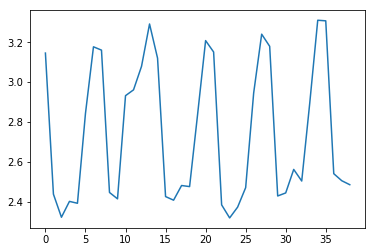

In [24]:
plt.plot(testpreds[129])

In [25]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [26]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.752316   
air_0164b9927d20bcc3_2017-04-23              1.308842   
air_0241aa3964b7f861_2017-04-23              2.392587   
air_0328696196e46f18_2017-04-23              2.157078   
air_034a3d5b40d5b1b1_2017-04-23              3.513076   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.767949  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.701883  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.941766  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.645836  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.551323

In [27]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [28]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [29]:
submission.to_csv("../submission/l5_3000_ridge_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')